In [1]:
cd /content/drive/MyDrive/DL_Project_2

/content/drive/MyDrive/DL_Project_2


In [109]:
import zipfile
import pandas as pd
import librosa as lib
from tqdm import tqdm
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import librosa as lib
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#Data-related Code Snippets

In [110]:
with zipfile.ZipFile('/content/drive/MyDrive/DL_Project_2/archive.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/drive/MyDrive/DL_Project_2')

In [111]:
def rename_files(root_path):
  for emotion in ["Sad","Romantic","Devotional","Party","Happy"]:
    emotional_path = os.path.join(root_path,str(emotion)+'/'+str(emotion))
    list_emotional = os.listdir(emotional_path)
    for emotion_piece in list_emotional:
      piece = os.path.join(emotional_path,emotion_piece)
      new_piece = os.path.join(emotional_path,emotion+str("_")+emotion_piece)
      os.rename(piece, new_piece)
    print("done")

In [112]:
rename_files('/content/drive/MyDrive/DL_Project_2')

done
done
done
done
done


In [113]:
def dataframe_creation(root_path):
  label=0
  audio_name = []
  label_list = []
  for emotion in ["Sad","Romantic","Devotional","Party","Happy"]:
    emotional_path = os.path.join(root_path,str(emotion)+'/'+str(emotion))
    list_emotional = os.listdir(emotional_path)
    for emotion_piece in list_emotional:
      piece = os.path.join(emotional_path,emotion_piece)
      audio_name.append(piece)
      label_list.append(label)
    label = label+1
  df = pd.DataFrame(columns=["Audio_Name","Emotion_Name"])
  df["Audio_Name"] = audio_name
  df["Emotion_Name"] = label_list
  return df

In [114]:
audio_df = dataframe_creation('/content/drive/MyDrive/DL_Project_2')

In [115]:
audio_df.to_csv('/content/drive/MyDrive/DL_Project_2/Audio_metafile.csv')

#Main Function

In [116]:
audio_df = pd.read_csv('/content/drive/MyDrive/DL_Project_2/Audio_metafile.csv')

In [117]:
audio_df

,Unnamed: 0,Audio_Name,Emotion_Name
0,0,/content/drive/MyDrive/DL_Project_2/Sad/Sad/Sa...,0
1,1,/content/drive/MyDrive/DL_Project_2/Sad/Sad/Sa...,0
2,2,/content/drive/MyDrive/DL_Project_2/Sad/Sad/Sa...,0
3,3,/content/drive/MyDrive/DL_Project_2/Sad/Sad/Sa...,0
4,4,/content/drive/MyDrive/DL_Project_2/Sad/Sad/Sa...,0
...,...,...,...
489,489,/content/drive/MyDrive/DL_Project_2/Happy/Happ...,4
490,490,/content/drive/MyDrive/DL_Project_2/Happy/Happ...,4
491,491,/content/drive/MyDrive/DL_Project_2/Happy/Happ...,4
492,492,/content/drive/MyDrive/DL_Project_2/Happy/Happ...,4


In [119]:
audio_df = audio_df.drop(columns=['Unnamed: 0'])

In [10]:
sample_1 = lib.load(audio_df["Audio_Name"][0])
x,y = sample_1
x.shape

(485304,)

In [13]:
hl = 512 # number of samples per time-step in spectrogram
hi = 224 # Height of image
wi = 224 # Width of image

In [14]:
window = x[0:wi*hl]

In [15]:
S = lib.feature.melspectrogram(y=window, sr=y, n_mels=hi, fmax=8000, hop_length=hl)
S_dB = lib.power_to_db(S, ref=np.max)

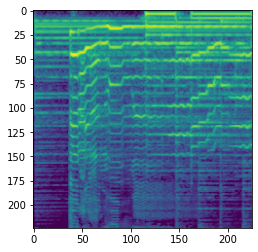

In [16]:
plt.imshow(S_dB)

# Dataset Class and Function

In [125]:
from torch.utils.data.sampler import SubsetRandomSampler

class Data_Prepare(Dataset):
  """
  The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
  """
  def __init__(self, data_frame, transform=None):
    self.data_frame = data_frame
    self.transform = transform
    self.hl = 512 # number of samples per time-step in spectrogram
    self.hi = 224 # Height of image
    self.wi = 224 # Width of image
  def __len__(self):
    # Return the length of the dataset
    return len(self.data_frame)
  def __getitem__(self, idx):
    # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
    if torch.is_tensor(idx):
      idx = idx.tolist()    
    audio_name = self.data_frame.iloc[idx, 0]
    audio_file, y = lib.load(audio_name)
    audio_window = audio_file[0:self.wi*self.hl]
    spectrogram = lib.feature.melspectrogram(y=audio_window, sr=y, n_mels=self.hi, fmax=8000, hop_length=self.hl)
    plot = lib.power_to_db(spectrogram, ref=np.max)
    plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))
    label = (self.data_frame.iloc[idx, -1])
    if self.transform:
      plot = self.transform(plot)
    return (plot, label)

def data_preparation(Data_Class, Dataframe, Mean, Std, Batch_Size = 128, Shuffle = False):
  transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(Mean, Std)])
  dataset_whole = Data_Class(data_frame=Dataframe,transform = transform)
  test_split = 0.2
  random_seed= 42
  dataset_size = len(dataset_whole)
  indices = list(range(dataset_size))
  split = int(np.floor(test_split * dataset_size))
  if Shuffle==True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_indices, test_indices = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_indices)
  test_sampler = SubsetRandomSampler(test_indices)
  train_loader = torch.utils.data.DataLoader(dataset = dataset_whole, batch_size = Batch_Size, pin_memory = True, num_workers=2, sampler=train_sampler)
  test_loader = torch.utils.data.DataLoader(dataset = dataset_whole, batch_size = Batch_Size, pin_memory = True, num_workers=2, sampler=test_sampler)
  return train_loader, test_loader

In [126]:
train, test = data_preparation(Data_Prepare, audio_df,(0,0,0),(1,1,1),Batch_Size=64, Shuffle=True)

# Helper Function

In [94]:
def bifurcation(model_name):
  model = model_name(pretrained=True)
  param = model.state_dict()
  for i in param.keys():
    print(i)

def selective_finetuning_single_layer(model_name, layer_name):
  model = model_name(pretrained=True)
  for name, param in model.named_parameters():
    if param.requires_grad and layer_name in name:
      param.requires_grad = True
    else:
      param.requires_grad = False
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
  return model.cuda(), torch.nn.CrossEntropyLoss().cuda(), optimizer

In [95]:
def grad_change(Loss_Function, Optimizer, Label = None, Predicted = None):
  Optimizer.zero_grad()
  loss = Loss_Function(Predicted, Label)
  loss.backward()
  Optimizer.step()
  return loss, Optimizer

def model(Train_Loader, Test_Loader, Epochs, Model_Class=None, Loss_Function=None, Optimizer=None):
  outputs_train=[]
  outputs_test=[]
  y_true=[]
  y_pred=[]
  for Epoch in range(Epochs):
    running_loss_train=0
    running_loss_test=0
    correct_train=0
    correct_test=0
    for (image, label) in tqdm(Train_Loader):
      image = image.cuda()
      label = torch.tensor(label).cuda()
      out = Model_Class(image)
      loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
      running_loss_train += loss.item()
      predicted_train = out.data.max(1, keepdim=True)[1]
      correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
      outputs_train.append((Epoch, running_loss_train/len(Train_Loader.dataset), 100*correct_train/len(Train_Loader.dataset)))
    with torch.no_grad():
      for (image, label) in Test_Loader:
        image = image.cuda()
        label = torch.tensor(label).cuda()
        out = Model_Class(image)
        loss = Loss_Function(out,label)
        running_loss_test += loss.item()
        predicted_test = out.data.max(1, keepdim=True)[1]
        if Epoch==(Epochs-1):
          y_pred.extend(predicted_test.cpu().numpy())
          y_true.extend(label.data.cpu().numpy())
        correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
        outputs_test.append((Epoch, running_loss_test/len(Test_Loader.dataset), 100*correct_test/len(Test_Loader.dataset)))
  return Model_Class, outputs_train, outputs_test, y_pred, y_true

# VGG16 Training and Inference

In [78]:
bifurcation(models.vgg16)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [80]:
import warnings
warnings.filterwarnings("ignore")

model_vgg16, loss_vgg16, optim_vgg16 = selective_finetuning_single_layer(models.vgg16, 'classifier')
model_vgg16 ,vgg16_train ,vgg16_test, vgg16_pred, vgg16_true = model(train,test,5,model_vgg16, loss_vgg16, optim_vgg16)

100%|██████████| 7/7 [03:37<00:00, 31.13s/it]


In [81]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(vgg16_true,vgg16_pred)
cf_matrix

array([[13,  5,  2,  1,  6,  0,  0],
       [11,  1,  2,  0,  2,  0,  0],
       [ 6,  4,  3,  0,  0,  2,  1],
       [ 7,  0,  3,  2,  3,  0,  0],
       [ 8,  3,  4,  3,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0]])

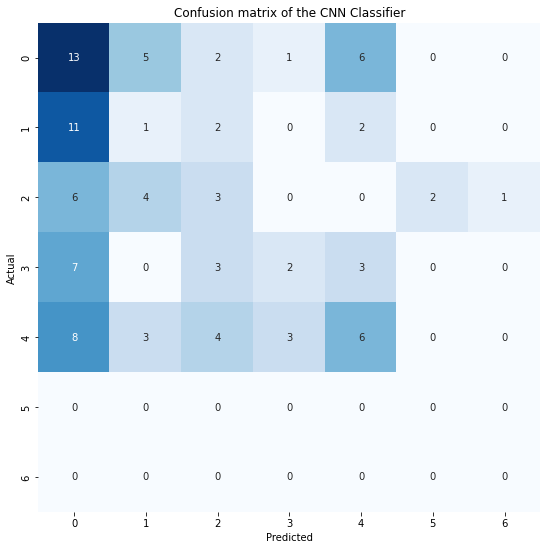

In [82]:
plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

# Mobilenet-V3-Small Training and Inference

In [123]:
bifurcation(models.mobilenet_v3_small)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.block.0.0.weight
features.1.block.0.1.weight
features.1.block.0.1.bias
features.1.block.0.1.running_mean
features.1.block.0.1.running_var
features.1.block.0.1.num_batches_tracked
features.1.block.1.fc1.weight
features.1.block.1.fc1.bias
features.1.block.1.fc2.weight
features.1.block.1.fc2.bias
features.1.block.2.0.weight
features.1.block.2.1.weight
features.1.block.2.1.bias
features.1.block.2.1.running_mean
features.1.block.2.1.running_var
features.1.block.2.1.num_batches_tracked
features.2.block.0.0.weight
features.2.block.0.1.weight
features.2.block.0.1.bias
features.2.block.0.1.running_mean
features.2.block.0.1.running_var
features.2.block.0.1.num_batches_tracked
features.2.block.1.0.weight
features.2.block.1.1.weight
features.2.block.1.1.bias
features.2.block.1.1.running_mean
features.2.block.1.1.running_var
features.2.block.1.1.nu

In [127]:
model_mobilenet_v3_small, loss_mobilenet_v3_small, optim_mobilenet_v3_small = selective_finetuning_single_layer(models.mobilenet_v3_small, 'classifier')
model_mobilenet_v3_small ,mobilenet_v3_small_train ,mobilenet_v3_small_test, mobilenet_v3_small_pred, mobilenet_v3_small_true = model(train,test,5,model_mobilenet_v3_small, loss_mobilenet_v3_small, optim_mobilenet_v3_small)

100%|██████████| 7/7 [01:58<00:00, 16.93s/it]


In [128]:
cf_matrix_mobilenet=confusion_matrix(mobilenet_v3_small_true,mobilenet_v3_small_pred)
cf_matrix_mobilenet

array([[14,  5,  6,  1,  1],
       [ 3,  6,  5,  2,  0],
       [ 1,  5,  7,  2,  1],
       [ 2,  3,  1,  8,  1],
       [ 1,  5,  3, 12,  3]])

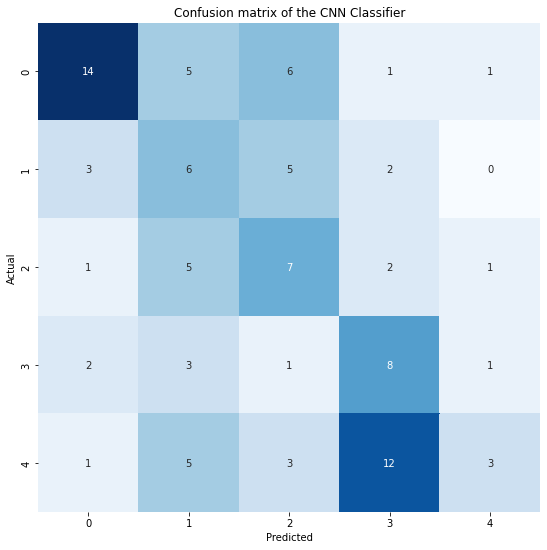

In [129]:
plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_mobilenet, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

# Densenet-121 Training and Inference

In [130]:
bifurcation(models.densenet121)

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.norm0.running_mean
features.norm0.running_var
features.norm0.num_batches_tracked
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.norm1.running_mean
features.denseblock1.denselayer1.norm1.running_var
features.denseblock1.denselayer1.norm1.num_batches_tracked
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.norm2.running_mean
features.denseblock1.denselayer1.norm2.running_var
features.denseblock1.denselayer1.norm2.num_batches_tracked
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.norm1.running_mean
features.denseblock1.denselayer2.norm1.running_var
features.denseblock1.denselayer2.norm1.num_batches_tracke

In [131]:
model_densenet121, loss_densenet121, optim_densenet121 = selective_finetuning_single_layer(models.densenet121, 'classifier')
model_densenet121 ,densenet121_train ,densenet121_test, densenet121_pred, densenet121_true = model(train,test,5,model_densenet121, loss_densenet121, optim_densenet121)

100%|██████████| 7/7 [02:07<00:00, 18.20s/it]


In [132]:
cf_matrix_densenet=confusion_matrix(densenet121_true,densenet121_pred)
cf_matrix_densenet

array([[ 9,  3,  2,  2, 11],
       [ 4,  2,  4,  2,  4],
       [ 4,  2,  5,  3,  2],
       [ 1,  5,  2,  3,  4],
       [ 4,  7,  7,  3,  3]])

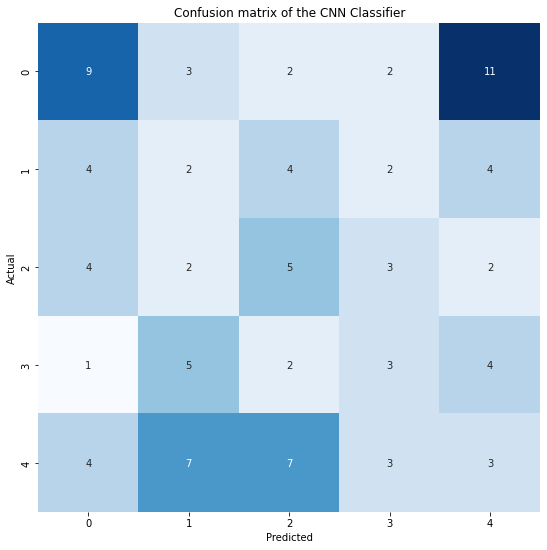

In [133]:
plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_densenet, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

# Efficientnet-B0 Training and Inference

In [137]:
bifurcation(models.efficientnet.efficientnet_b0)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.0.1.running_mean
features.1.0.block.0.1.running_var
features.1.0.block.0.1.num_batches_tracked
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.1.0.block.2.1.running_mean
features.1.0.block.2.1.running_var
features.1.0.block.2.1.num_batches_tracked
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.0.1.running_mean
features.2.0.block.0.1.running_var
features.2.0.block.0.1.num_batches_tracked
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.1.1.running_mean
feat

In [138]:
model_efficientnet_b0, loss_efficientnet_b0, optim_efficientnet_b0 = selective_finetuning_single_layer(models.efficientnet_b0, 'classifier')
model_efficientnet_b0 ,efficientnet_b0_train ,efficientnet_b0_test, efficientnet_b0_pred, efficientnet_b0_true = model(train,test,5,model_efficientnet_b0, loss_efficientnet_b0, optim_efficientnet_b0)

100%|██████████| 7/7 [01:58<00:00, 16.99s/it]


In [139]:
cf_matrix_efficientnet_b0=confusion_matrix(efficientnet_b0_true,efficientnet_b0_pred)
cf_matrix_efficientnet_b0

array([[ 8, 10,  2,  3,  4,  0,  0,  0],
       [ 3,  2,  4,  2,  4,  1,  0,  0],
       [ 4,  0,  8,  1,  1,  0,  1,  1],
       [ 3,  4,  1,  4,  3,  0,  0,  0],
       [ 0,  3,  2, 14,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

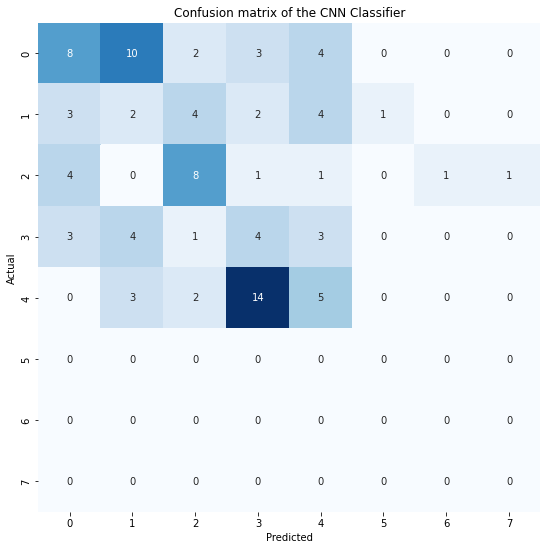

In [140]:
plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_efficientnet_b0, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

# Alexnet Training and Inference

In [148]:
bifurcation(models.alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


In [149]:
model_alexnet, loss_alexnet, optim_alexnet = selective_finetuning_single_layer(models.alexnet, 'classifier')
model_alexnet ,alexnet_train ,alexnet_test, alexnet_pred, alexnet_true = model(train,test,5,model_alexnet, loss_alexnet, optim_alexnet)

100%|██████████| 7/7 [02:05<00:00, 17.90s/it]


In [150]:
cf_matrix_alexnet=confusion_matrix(alexnet_true,alexnet_pred)
cf_matrix_alexnet

array([[10,  5, 10,  0,  2],
       [ 3,  3,  6,  0,  4],
       [ 0,  1, 11,  0,  4],
       [ 1,  1,  6,  2,  5],
       [ 1,  2, 11,  0, 10]])

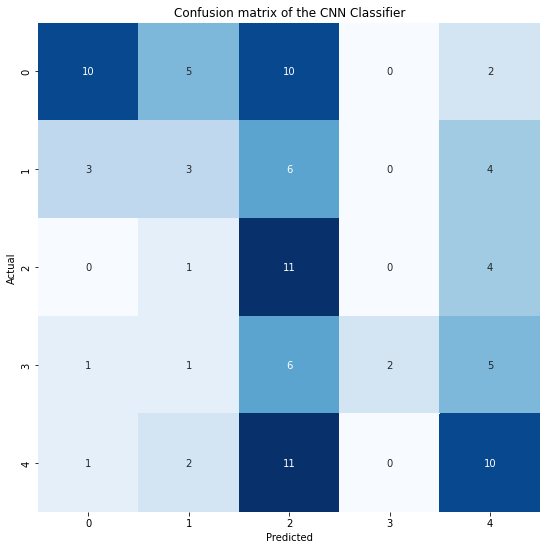

In [151]:
plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_alexnet, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

# ResNet18 Training and Inference

In [134]:
bifurcation(models.resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.downsample.0.weight
layer2.0.downsamp

In [135]:
model_resnet18, loss_resnet18, optim_resnet18 = selective_finetuning_single_layer(models.resnet18, 'fc')
model_resnet18 ,resnet18_train ,resnet18_test, resnet18_pred, resnet18_true = model(train,test,5,model_resnet18, loss_resnet18, optim_resnet18)

100%|██████████| 7/7 [01:57<00:00, 16.79s/it]


In [136]:
cf_matrix_resnet18=confusion_matrix(resnet18_true,resnet18_pred)
cf_matrix_resnet18

array([[5, 7, 5, 4, 6],
       [4, 2, 4, 1, 5],
       [4, 5, 1, 2, 4],
       [4, 3, 1, 4, 3],
       [6, 7, 3, 6, 2]])

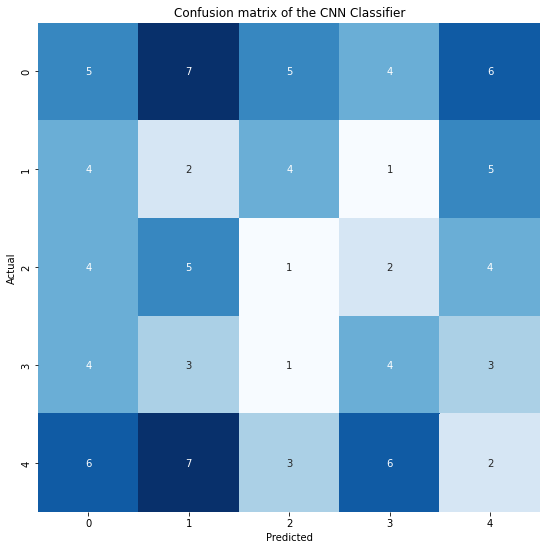

In [143]:
plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_resnet18, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

# Loss v/s Epochs and Accuracy v/s Epochs Curves

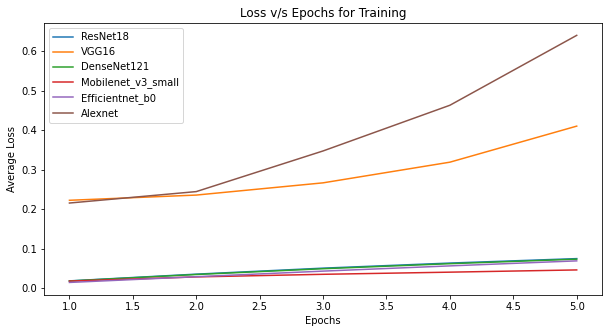

In [152]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_train[i][1] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Training")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

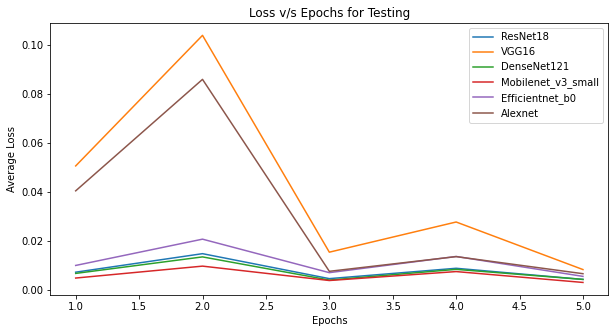

In [153]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_test[i][1] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Testing")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

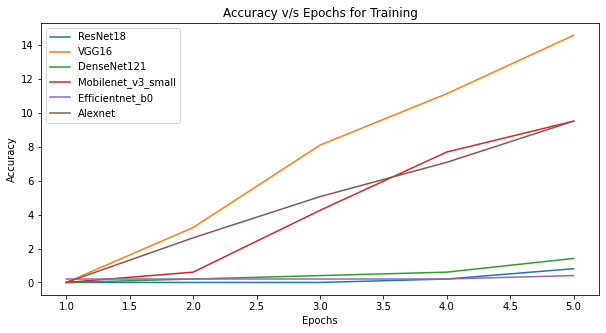

In [154]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_train[i][2].cpu().numpy() for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epochs for Training")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

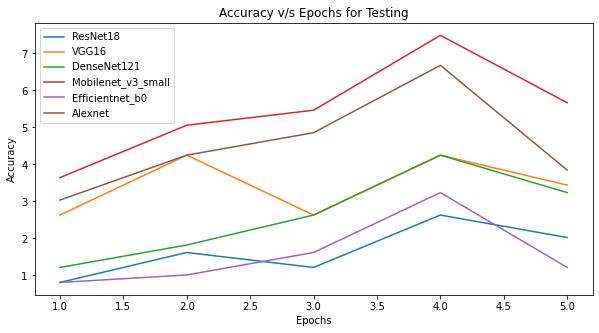

In [155]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_test[i][2].cpu().numpy() for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epochs for Testing")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

#Wandb Saves

In [177]:
import wandb

torch.save(model_vgg16, '/content/drive/MyDrive/DL_Project_2/model_vgg16.pth')
run = wandb.init(project='DL_Project_2')
artifact = wandb.Artifact('VGG16', type='VGG16')
artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_vgg16.pth')
run.log_artifact(artifact)
run.join()

In [178]:
torch.save(model_alexnet, '/content/drive/MyDrive/DL_Project_2/model_alexnet.pth')
run = wandb.init(project='DL_Project_2')
artifact = wandb.Artifact('alexnet', type='alexnet')
artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_alexnet.pth')
run.log_artifact(artifact)
run.join()

In [179]:
torch.save(model_efficientnet_b0, '/content/drive/MyDrive/DL_Project_2/model_efficientnet_b0.pth')
run = wandb.init(project='DL_Project_2')
artifact = wandb.Artifact('efficientnet_b0', type='efficientnet_b0')
artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_efficientnet_b0.pth')
run.log_artifact(artifact)
run.join()

In [180]:
torch.save(model_mobilenet_v3_small, '/content/drive/MyDrive/DL_Project_2/model_mobilenet_v3_small.pth')
run = wandb.init(project='DL_Project_2')
artifact = wandb.Artifact('mobilenet_v3_small', type='mobilenet_v3_small')
artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_mobilenet_v3_small.pth')
run.log_artifact(artifact)
run.join()

In [181]:
torch.save(model_resnet18, '/content/drive/MyDrive/DL_Project_2/model_resnet18.pth')
run = wandb.init(project='DL_Project_2')
artifact = wandb.Artifact('resnet18', type='resnet18')
artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_resnet18.pth')
run.log_artifact(artifact)
run.join()

In [182]:
torch.save(model_densenet121, '/content/drive/MyDrive/DL_Project_2/model_densenet121.pth')
run = wandb.init(project='DL_Project_2')
artifact = wandb.Artifact('densenet121', type='densenet121')
artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_densenet121.pth')
run.log_artifact(artifact)
run.join()

In [157]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 31.1 MB/s 
     |████████████████████████████████| 144 kB 85.3 MB/s 
     |████████████████████████████████| 181 kB 76.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=7000b086845d00a151506e08761deceb53fad6e3e8d0d19098a482fda49f31c9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# End-To-End Pipeline

Enter the File-Path for 10-Seconds Hindi-Music Based Emotion Classification :- /content/drive/MyDrive/DL_Project_2/Happy/Happy/Happy_1.wav
 
Pre-Trained Models List

1. Alexnet

2. EfficientNet-B0

3. ResNet18

4. VGG16

5. MobileNet_V3_Small

6. DenseNet121


Enter the Choice of Model :- 
1
Predicted Emotion -->Happy


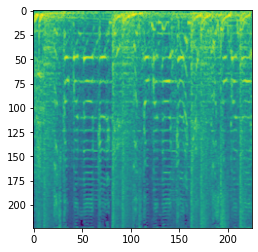

In [187]:
path = input("Enter the File-Path for 10-Seconds Hindi-Music Based Emotion Classification :- ")
input_audio , y = lib.load(path)
hl = 512 # number of samples per time-step in spectrogram
hi = 224 # Height of image
wi = 224 # Width of image
audio_window = input_audio[0:wi*hl]
spectrogram = lib.feature.melspectrogram(y=audio_window, sr=y, n_mels=hi, fmax=8000, hop_length=hl)
plot = lib.power_to_db(spectrogram, ref=np.max)
plt.imshow(plot)
final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

print(" ")
print("Pre-Trained Models List\n")
print("1. Alexnet\n")
print("2. EfficientNet-B0\n")
print("3. ResNet18\n")
print("4. VGG16\n")
print("5. MobileNet_V3_Small\n")
print("6. DenseNet121\n\n")
model_choice = int(input("Enter the Choice of Model :- \n"))
if model_choice==1:
  model = torch.load('/content/drive/MyDrive/DL_Project_2/model_alexnet.pth', map_location='cuda:0')
if model_choice==2:
  model = torch.load('/content/drive/MyDrive/DL_Project_2/model_eddicientnet_b0.pth', map_location='cuda:0')
if model_choice==3:
  model = torch.load('/content/drive/MyDrive/DL_Project_2/model_resnet18.pth', map_location='cuda:0')
if model_choice==4:
  model = torch.load('/content/drive/MyDrive/DL_Project_2/model_vgg16.pth', map_location='cuda:0')
if model_choice==5:
  model = torch.load('/content/drive/MyDrive/DL_Project_2/model_mobilenet_v3_small.pth', map_location='cuda:0')
if model_choice==6:
  model = torch.load('/content/drive/MyDrive/DL_Project_2/model_densenet121.pth', map_location='cuda:0')

class_map = {0:'Sad',1:'Romantic',2:'Devotional',3:'Party',4:'Happy'}
model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,0,0), (1,1,1))])(final_plot)[None]
with torch.no_grad():
  output = model(model_input.cuda())
  class_predict = output.data.max(1, keepdim=True)[1]
  print("\nPredicted Emotion -->"+class_map[class_predict.cpu().numpy()[0][0]])